# **Sea Level Rise - Project 4**



 The aim of this project was to study the sea level rise from 1998 to 2016 and to predict from these data the sea level in 2100.

 The project was divided into 3 main parts: 
-  A first part of data visualization: trying to see if a rise in water level is observable
-  In a second part, we tried to identifies important relationships in ssh with the technique of decomposition into principal components (PCA).
-  In the last part, we tried to predict the rise in ocean levels by means of different techniques (SVR, Regression, Neural Network,...)


</br>
</br>

This project is a cooperation between the students from IMT Atlantique and Ensta Bretagne. This project was realised by :
- Vanessa Vandenberghe
- Wadia Ferjani
- Marceau Michel
- Mathieu Pierronne

In [1]:
%%bash
apt-get install libgeos-3* libgeos-dev
pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-3.6.2 is already the newest version (3.6.2-1build2).
libgeos-3.6.2 set to manually installed.
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10

ERROR: File "setup.py" not found for legacy project https://github.com/matplotlib/basemap/archive/master.zip.


In [ ]:
pip install statsmodels --upgrade

     |████████████████████████████████| 9.5MB 8.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import seaborn as sns
sns.set()
import warnings
import imageio
from plotnine import *   # plotting
from google.colab import files   # file download
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<360:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right",shrink=1.25)
    cb.set_label(var_name,fontsize=15)
  
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)
    

# **I/ Data Visualisation** 

## a) Average of the Sea level

In [ ]:
%%bigquery --project alert-ground-261008 output_global
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360
group by lon,lat
order by lon,lat

Text(0.5, 1.0, 'Sea level average between 1998 and 2015')

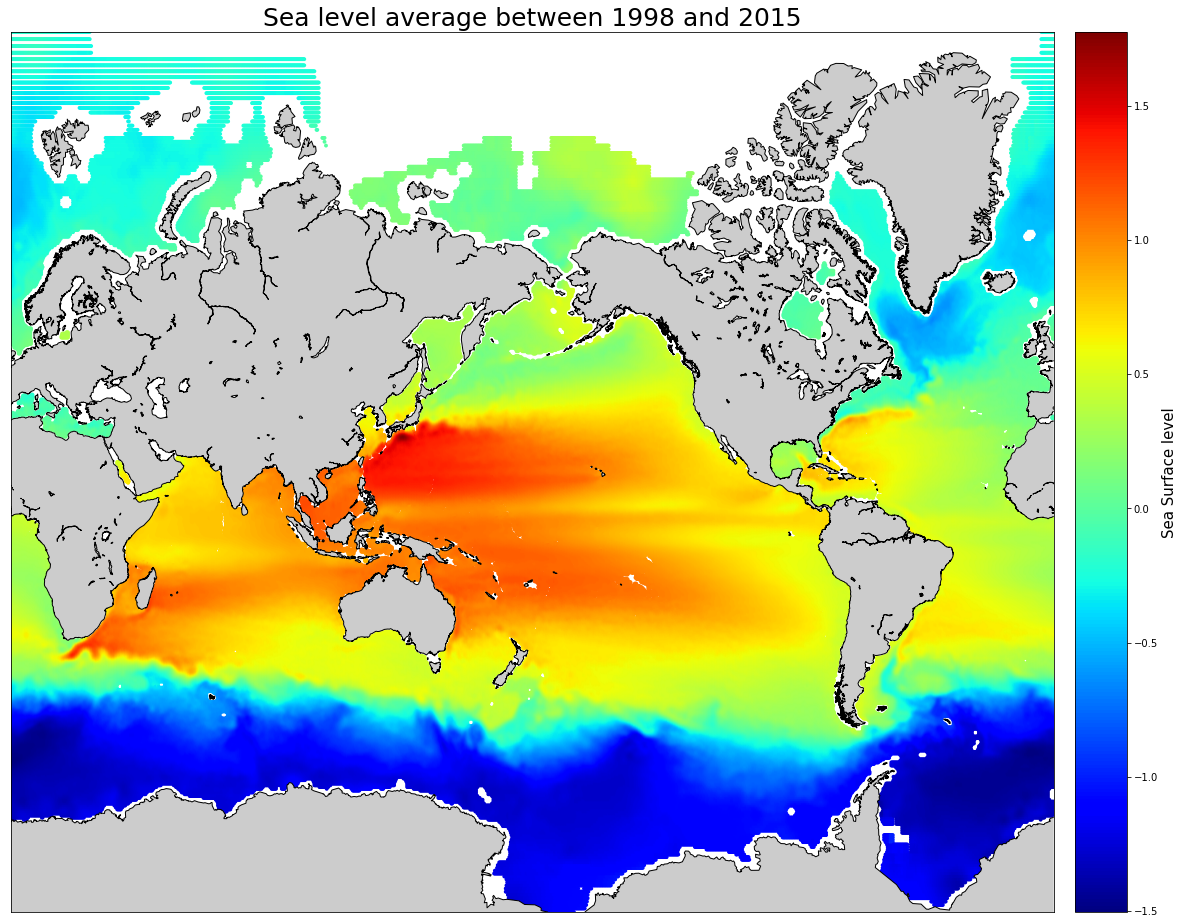

In [ ]:
plt.figure(figsize=(20,40))
plot_im(output_global.lon,output_global.lat,output_global.mean_ssh,15,'Sea Surface level')
plt.title('Sea level average between 1998 and 2015', fontsize=25)

We can observe that the water height is much greater at the level of the equator. This is explained by the fact that the sun's rays arrive perpendicular to the level of the equator: the solar energy is then more concentrated and it is hotter there.

When water heats up, it expands. The sea level is therefore higher at the level of the equator.

## b) Global rise of the sea level

#### 1) Sea level in 1998 and in 2015

In [ ]:
# Time attribute is in days.
%%bigquery --project alert-ground-261008 output_1998
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35 AND time>=729390.0 AND time<=729755.0
group by lon,lat
order by lon,lat

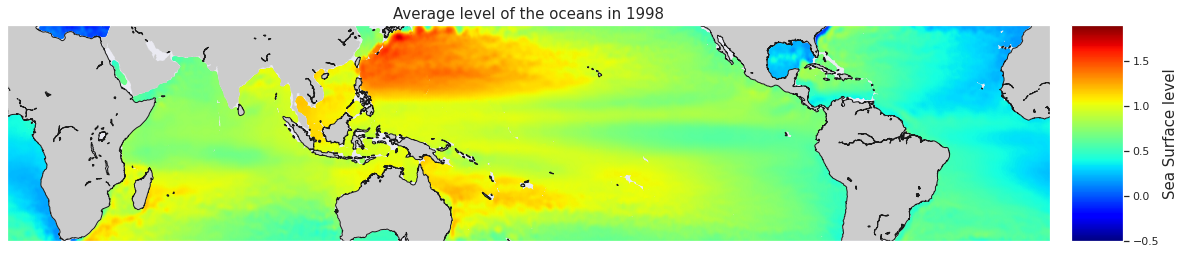

In [ ]:
plot_im(output_1998.lon,output_1998.lat,output_1998.mean_ssh,15,'Sea Surface level')
plt.title('Average level of the oceans in 1998', fontsize=15)
clim([-0.5,1.90])

In [ ]:
%%bigquery --project alert-ground-261008 output_2015
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35 AND time>=735598.0 AND time<=735963.0
group by lon,lat
order by lon,lat

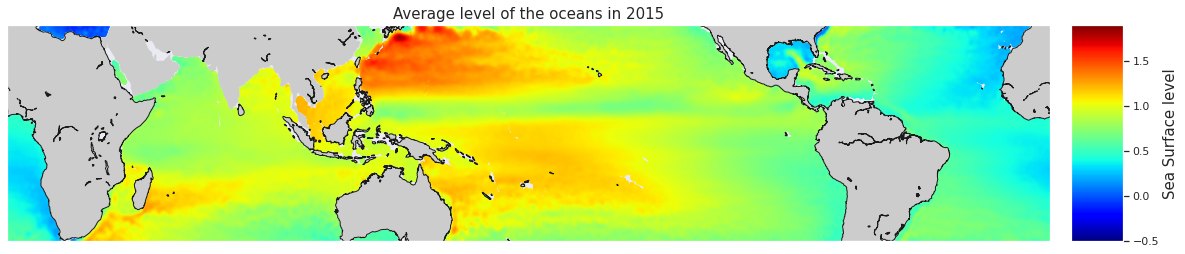

In [ ]:
plot_im(output_2015.lon,output_2015.lat,output_2015.mean_ssh,15,'Sea Surface level')
plt.title('Average level of the oceans in 2015', fontsize=15)
clim([-0.5,1.90]) #limits of the colorbar

By comparing the sea level in 1998 with that in 2015, it can be observed that the sea level in 2015 is much higher than in 1998. However, this comparison is not necessarily relevant since we are comparing two point years. It would then be possible to observe the evolution of the sea level year by year to confirm this trend.

### 2) Evolution of sea level year by year

In [ ]:
%%bigquery --project alert-ground-261008 output_global
SELECT  lon,lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35 
group by lon,lat
order by lon,lat

In [ ]:
%%bigquery --project alert-ground-261008 output_sshByYear
SELECT  year, lon, lat, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>=0 AND lon<=360 AND lat>=-35 AND lat<=35
group by lon,lat, year
order by year

In [ ]:
#year 
year = np.unique(output_sshByYear.year)

for k in range(len(year)): 
  # We get the longitude, latitude and mean_ssh per year
  lon_ = output_sshByYear.lon.values[np.where(output_sshByYear.year.values == year[k])]
  lat_ = output_sshByYear.lat.values[np.where(output_sshByYear.year.values == year[k])]
  meanSSH_ = output_sshByYear.mean_ssh.values[np.where(output_sshByYear.year.values == year[k])] - output_global.mean_ssh.values

  # We plot the map by year
  figure()
  subplot()
  plot_im(lon_,lat_,meanSSH_ ,15,'Sea Surface level')
  plt.title("Average level of the oceans in " + str(year[k]), fontsize=20)
  clim([-0.5,1.90])

Output hidden; open in https://colab.research.google.com to view.

###### Creation of a GIF of the previous result 

In [ ]:
year = np.unique(output_sshByYear.year)

for k in range(len(year)): 
  # We get the longitude, latitude and mean_ssh per year
  lon_ = output_sshByYear.lon.values[np.where(output_sshByYear.year.values == year[k])]
  lat_ = output_sshByYear.lat.values[np.where(output_sshByYear.year.values == year[k])]
  meanSSH_ = output_sshByYear.mean_ssh.values[np.where(output_sshByYear.year.values == year[k])] - output_global.mean_ssh

  #We save the map by year
  plot_im(lon_,lat_,meanSSH_ ,15,'Sea Surface level')
  plt.title("Average level of the oceans in " + str(year[k]), fontsize=20)
  clim([0,1.5])
  savefig(str(k)+'.png')

In [ ]:
images = list()
for k in range(len(year)):
    images.append(imageio.imread(str(k) + '.png'))
imageio.mimsave("gapminer.gif", images, fps=1)

In [ ]:
files.download('gapminer.gif')

## c) Local Regression

We extract a spatial subset of the yearly mean of sea surface height (1 lat, resp. lon, out of 10) and compute a temporal linear regression on each point in order to extract the local trend of seal level rise. 

In [ ]:
%%bigquery --project alert-ground-261008 data_subset
SELECT lon, lat, AVG(ssh) as mean_ssh,
EXTRACT(YEAR FROM DATE_ADD(DATE "0001-1-1", INTERVAL CAST(time as INT64) DAY)) as year,
from bdo2020.bdo2020.1998_2015
WHERE lat IN
(-39.125, -36.625, -34.125, -31.625, -29.125, -26.625, -24.125, -21.625, -19.125,
 -16.625, -14.125, -11.625,  -9.125,  -6.625,  -4.125,  -1.625,   0.875,   3.375,
   5.875,   8.375,  10.875,  13.375,  15.875,  18.375,  20.875,  23.375,  25.875,
  28.375,  30.875,  33.375,  35.875,  38.375)
AND lon IN
(1.25000e-01, 2.62500e+00, 5.12500e+00, 7.62500e+00, 1.01250e+01, 1.26250e+01,
 1.51250e+01, 1.76250e+01, 2.01250e+01, 2.26250e+01, 2.51250e+01, 2.76250e+01,
 3.01250e+01, 3.26250e+01, 3.51250e+01, 3.76250e+01, 4.01250e+01, 4.26250e+01,
 4.51250e+01, 4.76250e+01, 5.01250e+01, 5.26250e+01, 5.51250e+01, 5.76250e+01,
 6.01250e+01, 6.26250e+01, 6.51250e+01, 6.76250e+01, 7.01250e+01, 7.26250e+01,
 7.51250e+01, 7.76250e+01, 8.01250e+01, 8.26250e+01, 8.51250e+01, 8.76250e+01,
 9.01250e+01, 9.26250e+01, 9.51250e+01, 9.76250e+01, 1.00125e+02, 1.02625e+02,
 1.05125e+02, 1.07625e+02, 1.10125e+02, 1.12625e+02, 1.15125e+02, 1.17625e+02,
 1.20125e+02, 1.22625e+02, 1.25125e+02, 1.27625e+02, 1.30125e+02, 1.32625e+02,
 1.35125e+02, 1.37625e+02, 1.40125e+02, 1.42625e+02, 1.45125e+02, 1.47625e+02,
 1.50125e+02, 1.52625e+02, 1.55125e+02, 1.57625e+02, 1.60125e+02, 1.62625e+02,
 1.65125e+02, 1.67625e+02, 1.70125e+02, 1.72625e+02, 1.75125e+02, 1.77625e+02,
 1.80125e+02, 1.82625e+02, 1.85125e+02, 1.87625e+02, 1.90125e+02, 1.92625e+02,
 1.95125e+02, 1.97625e+02, 2.00125e+02, 2.02625e+02, 2.05125e+02, 2.07625e+02,
 2.10125e+02, 2.12625e+02, 2.15125e+02, 2.17625e+02, 2.20125e+02, 2.22625e+02,
 2.25125e+02, 2.27625e+02, 2.30125e+02, 2.32625e+02, 2.35125e+02, 2.37625e+02,
 2.40125e+02, 2.42625e+02, 2.45125e+02, 2.47625e+02, 2.50125e+02, 2.52625e+02,
 2.55125e+02, 2.57625e+02, 2.60125e+02, 2.62625e+02, 2.65125e+02, 2.67625e+02,
 2.70125e+02, 2.72625e+02, 2.75125e+02, 2.77625e+02, 2.80125e+02, 2.82625e+02,
 2.85125e+02, 2.87625e+02, 2.90125e+02, 2.92625e+02, 2.95125e+02, 2.97625e+02,
 3.00125e+02, 3.02625e+02, 3.05125e+02, 3.07625e+02, 3.10125e+02, 3.12625e+02,
 3.15125e+02, 3.17625e+02, 3.20125e+02, 3.22625e+02, 3.25125e+02, 3.27625e+02,
 3.30125e+02, 3.32625e+02, 3.35125e+02, 3.37625e+02, 3.40125e+02, 3.42625e+02,
 3.45125e+02, 3.47625e+02, 3.50125e+02, 3.52625e+02, 3.55125e+02, 3.57625e+02)
AND time < 735963 # 2016/01/01
GROUP BY year, lat, lon
ORDER BY year, lat, lon

In [ ]:
year = np.unique(data_subset.year)
# We create vectors with the coordinates in latitude and longitude for each point
lon_ = data_subset.lon.values[np.where(data_subset.year.values == year[0])]
lat_ = data_subset.lat.values[np.where(data_subset.year.values == year[0])]
# We verify that the vector's size doesn't change over year. (If there are some missing values) 
for y in range(1, len(year)):
  if data_subset.lon.values[np.where(data_subset.year.values == year[y])].size != lon_.size and data_subset.lat.values[np.where(data.year_subset.values == year[y])].size != lat_.size:
    print('ERROR')
    print('Year', y + year[0])
# We put data into a vector of shape (Nsamples, Nfeatures)
data_vec = np.reshape(data_subset.mean_ssh.values, (year.size, lon_.size))

In [ ]:
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import PercentFormatter

# We perform linear regression for each space point
coefs = np.zeros((lon_.shape))
rmse = np.zeros((lon_.shape))
for i in range(len(coefs)):
    reg = LinearRegression()
    reg.fit(year.reshape(-1, 1), data_vec[:, i])
    coefs[i] = reg.coef_ * 1000    
    rmse[i] = np.log10(np.mean(np.sum((data_vec[:, i] - reg.predict(year.reshape(-1, 1)))**2)))

mean trend [mm/year] : 3.174580735990884


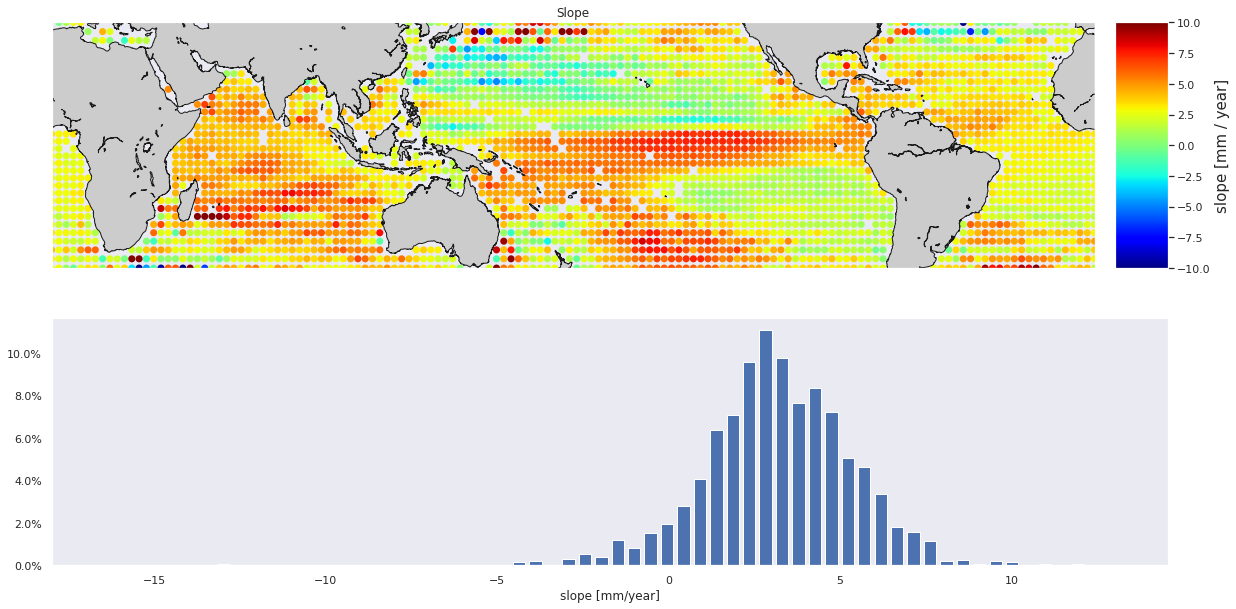

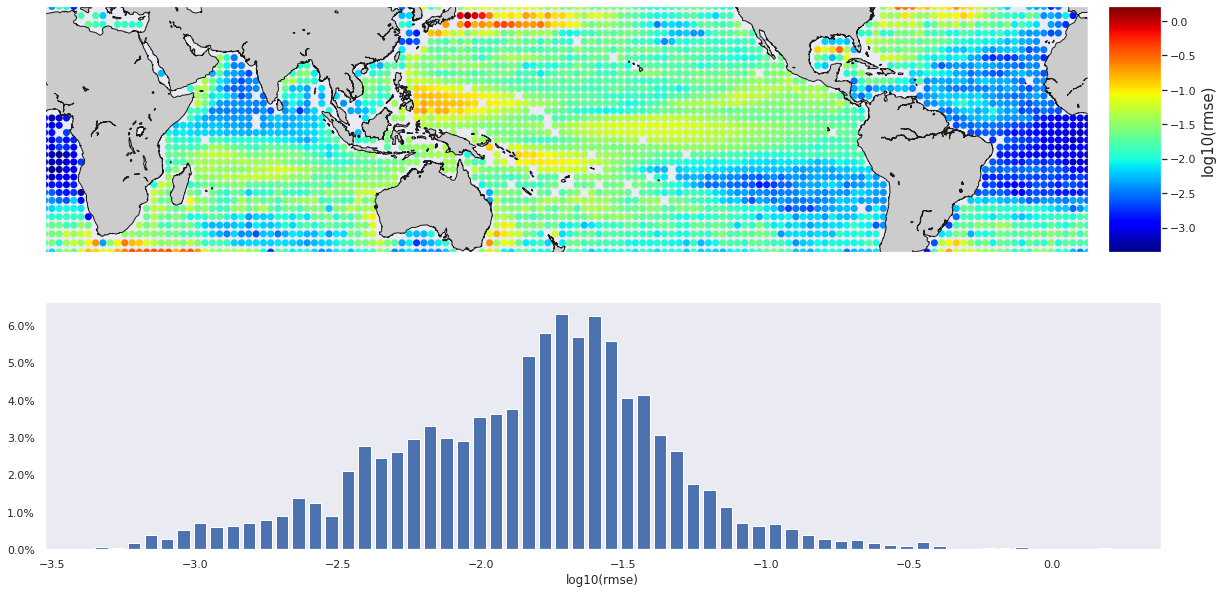

In [ ]:
rcParams["figure.figsize"] = (20,10)
figure()
subplot(211)
plot_im(lon_,lat_,coefs,50,'slope [mm / year]')
title('Slope')
clim([-10,10])
subplot(212)
l = coefs
hist(l.flatten(), bins=l.size // 50, weights=np.ones(l.size) / l.size, rwidth=0.75)
gca().yaxis.set_major_formatter(PercentFormatter(1))
xlabel('slope [mm/year]')
grid()
print('mean trend [mm/year] :', np.nanmean(coefs))

rcParams["figure.figsize"] = (20,10)
figure()
subplot(211)
plot_im(lon_,lat_,rmse,50,'log10(rmse)')
subplot(212)
l = rmse
hist(l.flatten(), bins=l.size // 50, weights=np.ones(l.size) / l.size, rwidth=0.75)
gca().yaxis.set_major_formatter(PercentFormatter(1))
xlabel('log10(rmse)')
grid()

The mean sea surface elevation value we obtain (3.17 mm/year) is consistent with the one we can find in the literature (3.2 ± 0.4 mm/year).

Church, J.A., White, N.J. Sea-Level Rise from the Late 19th to the Early 21st Century. Surv Geophys 32, 585–602 (2011). https://doi.org/10.1007/s10712-011-9119-1

# **II/ Principal Components Analysis** 

On the same dataset, we compute a PCA, ie. a decomposition of the SSH as:
$ SSH(t)\approx \sum_{i=1}^{k}\alpha_{i}(t)EOF_{i} $

We want see if some known meteorological phenomena can explain some variance in data.

In [ ]:
from sklearn.decomposition import PCA
NbPCA = 18
pca = PCA(NbPCA)
pca.fit(data_vec)
# The coefficients associated with each component are calculated.
PC_coef = pca.transform(data_vec)
PCA_c = pca.components_
PCA_m = pca.mean_

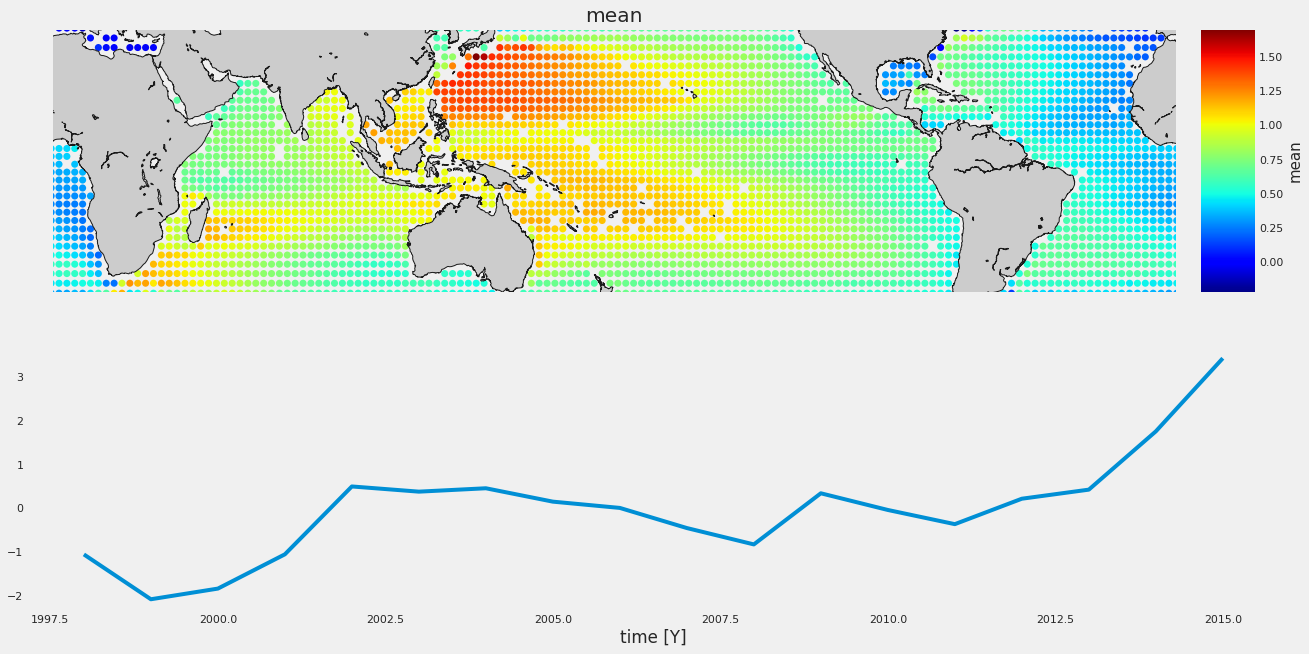

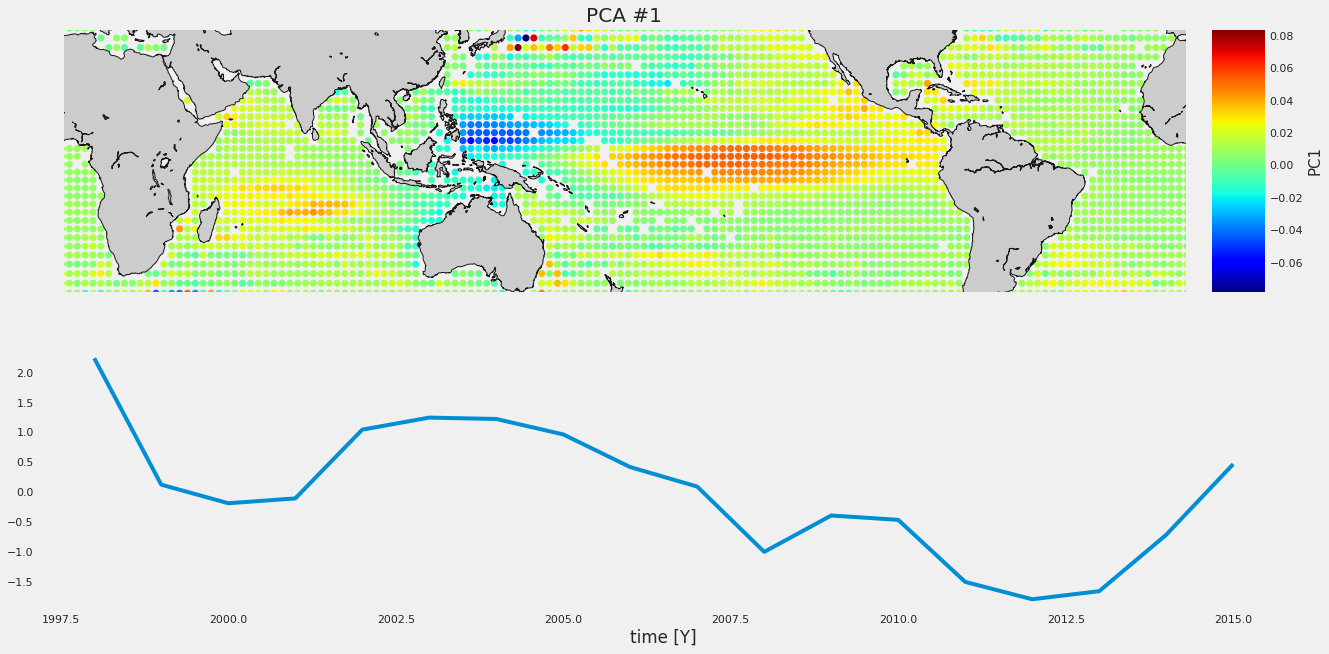

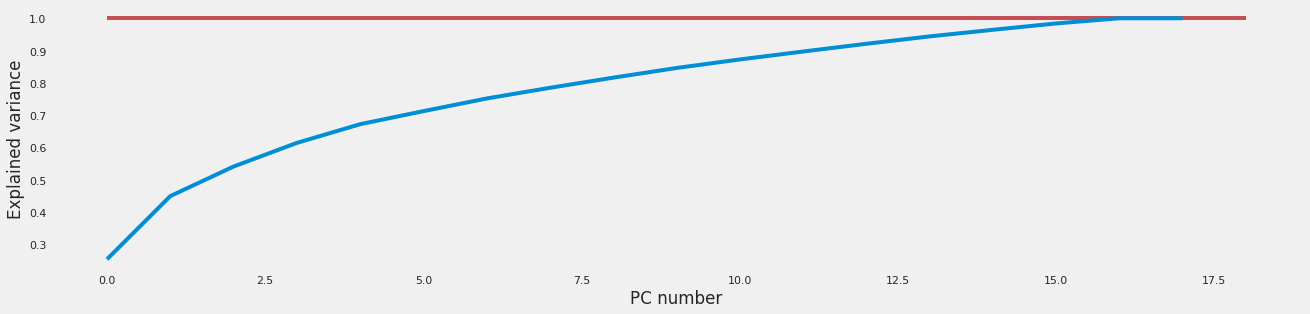

In [ ]:
rcParams["figure.figsize"] = (20,10)
figure()
subplot(211)
plot_im(lon_,lat_,PCA_m,50,'mean')
title('mean');
subplot(212)
plot(year, PC_coef[:, 0])
xlabel('time [Y]')
grid()

rcParams["figure.figsize"] = (20,10)
figure()
subplot(211)
plot_im(lon_,lat_,PCA_c[0],50,'PC1')
title('PCA #1');
subplot(212)
plot(year, PC_coef[:, 1])
xlabel('time [Y]')
grid()

rcParams["figure.figsize"] = (20, 10)
figure()
subplot(211)
plot(np.cumsum(pca.explained_variance_ratio_))
hlines(1, 0, NbPCA, colors='r')
xlabel('PC number')
ylabel('Explained variance')
grid()

The first time series associated with the mean component in our decomposition shows the sea level rise.
</br>
The first component seems to describe the El Niño / La Nina oscillation which present high temperatures in the eastern part of the South Pacific Ocean. When we look at The PDO (Pacific Decadal Oscillation) values can be retrieved from the NOAA website. This indicator is strongly correlated to the coefficients associated with this component.

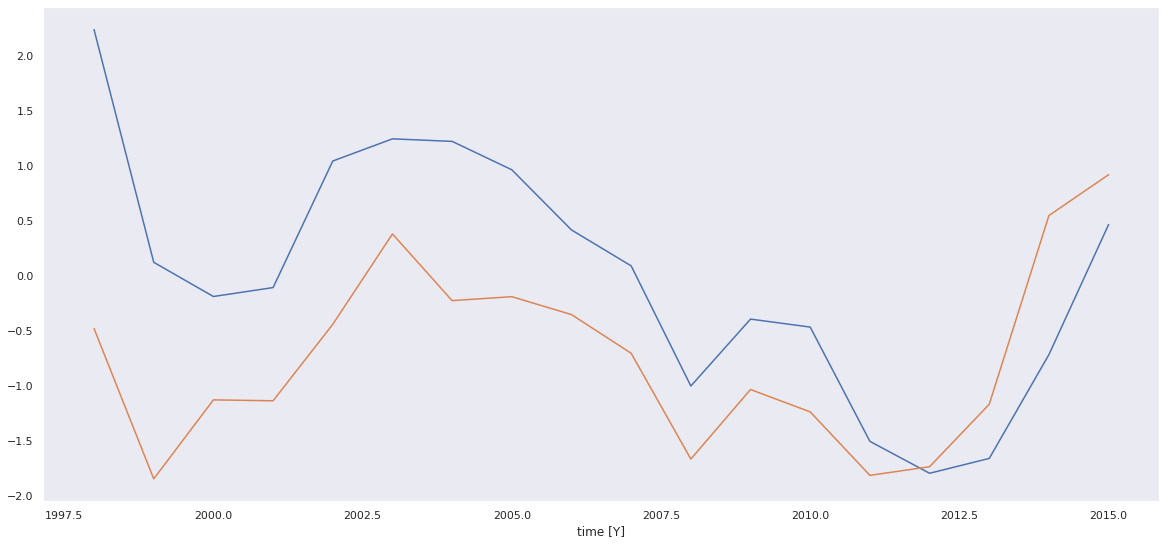

In [ ]:
PDO = np.array([1.05,  1.52,  1.29,  0.03, -0.83, -0.78, -1.16, -0.87, -1.70, -2.23, -0.97, -1.09,
-0.78, -1.06, -1.18, -1.85, -2.32, -2.34, -1.87, -1.84, -2.24, -2.54, -2.18, -1.92,
-2.20, -1.28, -0.66, -0.63, -0.81, -0.64, -1.51, -1.68, -1.45, -1.61, -1.04,  0.00,
 0.48, -0.01, -0.41, -1.18, -1.12, -1.22, -2.21, -1.68, -1.98, -1.91, -1.25, -1.12,
-0.42, -1.51, -1.27, -1.23, -1.30, -1.18, -0.71,  0.11, -0.21, -0.20,  1.08,  1.57,
 1.45,  1.23,  1.01,  0.36,  0.21, -0.42,  0.37,  0.63, -0.17,  0.74, -0.23, -0.60,
-0.55, -0.21, -0.15, -0.00,  0.61, -0.11,  0.04,  0.24,  0.02, -0.72, -1.22, -0.64,
-0.15, -0.01,  0.70,  0.28,  1.36,  0.85,  0.11, -0.42, -0.99, -2.00, -1.89, -0.10,
 0.54,  0.38, -0.74, -0.54, -0.37,  0.21,  0.39, -0.85, -1.54, -0.46, -0.81, -0.42,
-0.69, -0.71, -1.10, -0.46, -0.29, -0.07,  0.43,  0.09, -0.97, -2.33, -1.46, -0.87,
-1.50, -1.46, -1.26, -1.79, -1.62, -1.85, -1.96, -1.85, -1.87, -1.90, -1.59, -1.31,
-1.81, -1.78, -2.06, -2.23, -1.32, -0.73, -0.71, -0.49,  0.33, -0.13, -0.94, -0.51,
 0.25, -0.16, -0.04, -0.18, -0.79, -1.99, -2.21, -2.45, -1.60, -1.57, -2.04, -2.04,
-1.80, -1.46, -1.28, -1.02, -0.66, -1.08, -2.30, -2.37, -2.50, -1.92, -2.95, -2.40,
-1.85, -1.35, -1.66, -1.01, -2.12, -1.63, -2.40, -2.60, -2.99, -1.22, -0.66, -1.31,
-1.10, -1.42, -1.48, -0.72, -0.40, -1.19, -1.34, -1.56, -1.00, -1.65, -1.09, -1.04,
-0.56, -0.42,  0.30,  0.36,  1.26, -0.29,  0.24,  0.33,  0.75,  1.42,  1.35,  1.85,
 1.51,  1.52,  1.34,  0.90,  0.33,  0.82,  1.41,  0.98,  0.96,  0.83,  0.16, 0.28])

PDO = PDO.reshape((18, 12))
PDO = np.mean(PDO, axis=1)


rcParams["figure.figsize"] = (20,20)
figure()
subplot(211)
plot(year, PC_coef[:, 1])
plot(year, PDO)
xlabel('time [Y]')
grid()

# **III/ Time series analysis** 

In [ ]:
%%bigquery --project alert-ground-261008 data
SELECT time, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-35 AND lat<35
GROUP BY time
ORDER BY time

In [ ]:
# Create a Series
mean_ssh_ts = pd.Series(np.array(data['mean_ssh'].astype('float64')), index=pd.date_range('1998-01-01','2015-12-31',freq='D'))

In [ ]:
mean_ssh_ts

1998-01-01    0.778453
1998-01-02    0.777943
1998-01-03    0.777465
1998-01-04    0.776976
1998-01-05    0.776502
                ...   
2015-12-27    0.841837
2015-12-28    0.841651
2015-12-29    0.841408
2015-12-30    0.841080
2015-12-31    0.840709
Freq: D, Length: 6574, dtype: float64

## a) Time series decomposition

The first step on our time series analysis is to identify the three components of time series data:

*   Trend
*   Seasonality
*   Residuals

Time series decomposition involves thinking of a series as a combination of trend, seasonality, and noise components.

 Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.


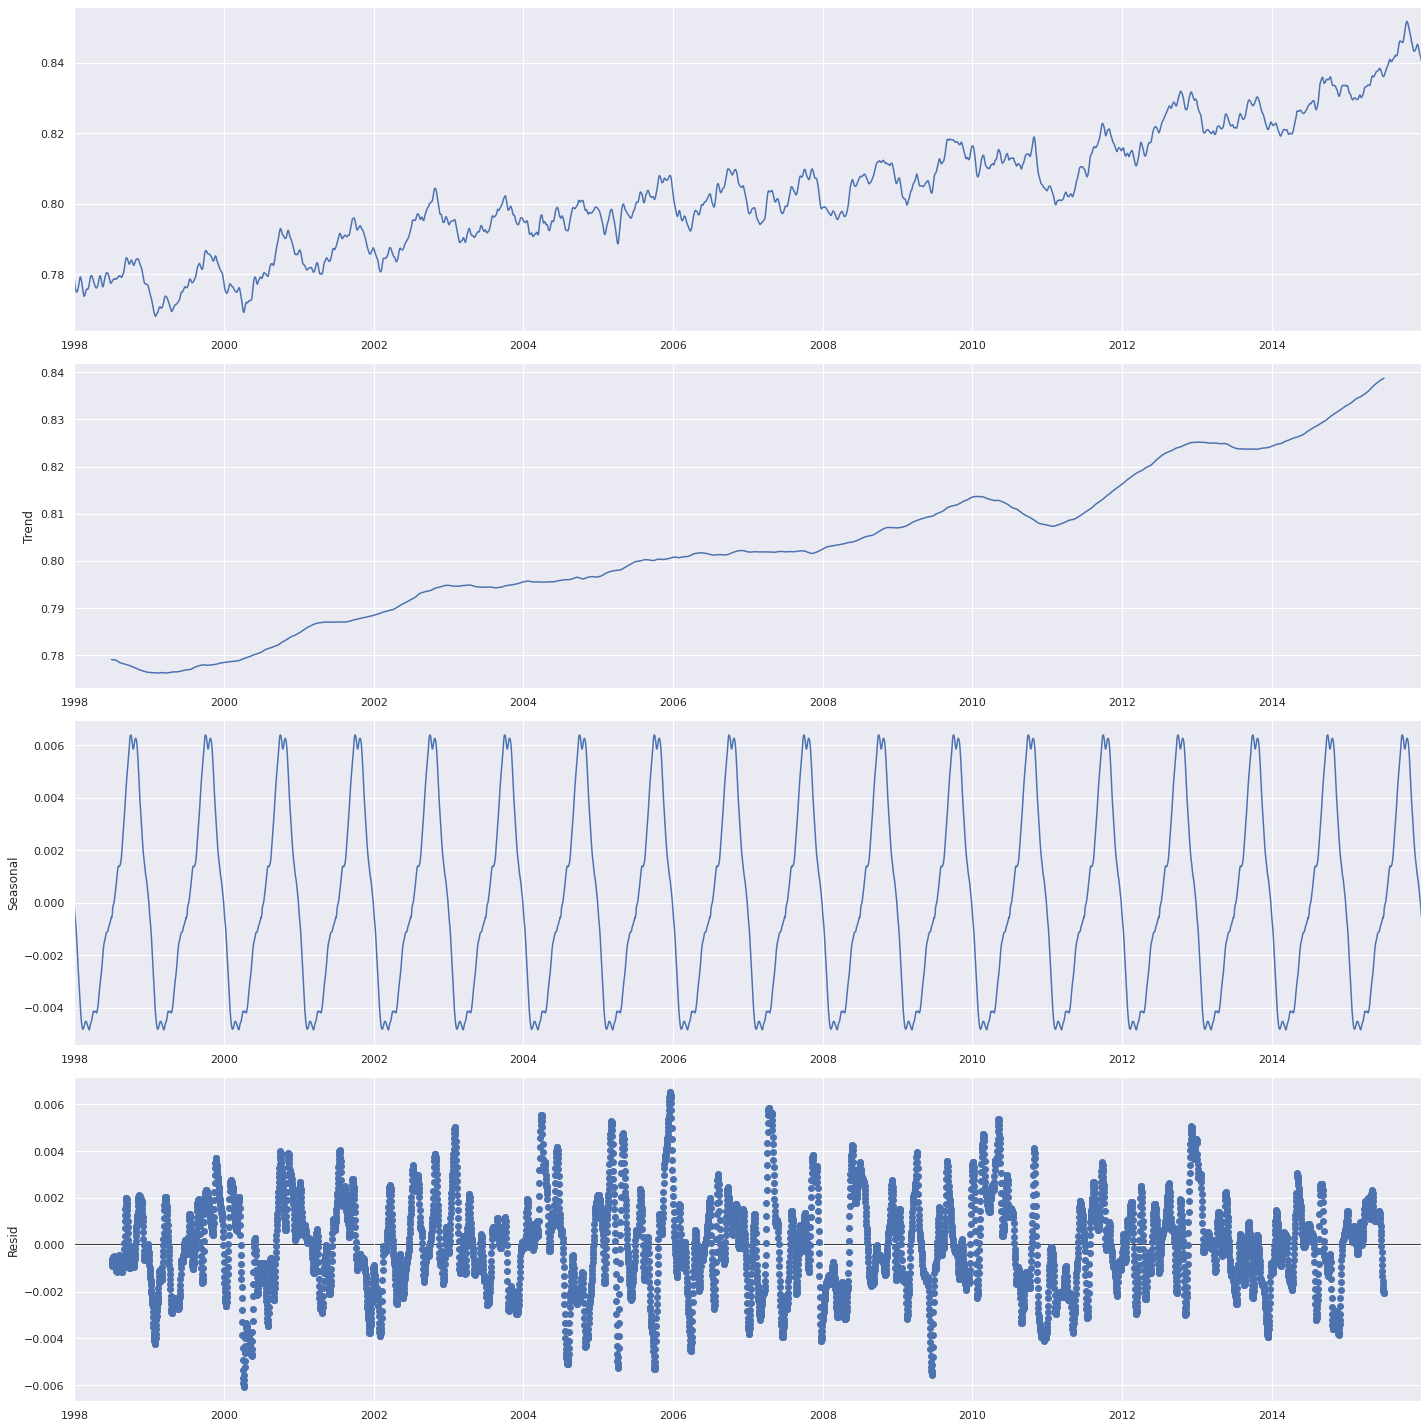

In [ ]:
import statsmodels.api as sm
decomposition=sm.tsa.seasonal_decompose(mean_ssh_ts,freq=365)
fig=decomposition.plot()

By doing the decomposition of the mean SSH time series we can interpret that :
- We have an overall upward trend but it's not always stable especially between 2010 and 2015 where we can clearly see that the trend of the mean SSH at this period sometimes take the shape of a curved line with ups and downs. For example, during 2009, the trend increased until the first month of 2010. But, during 2010 we have a dramatic decreasing of the trend. Then, the trend incresed once again starting from 2011.
- We have a yearly seasonality which means that we have some predictable fluctuation during the seasons like winter and summer that occurs and repeats every year.
- we have random residuals that can be sometimes significant.


#### Plotting Original Data and Trend Data on same plot

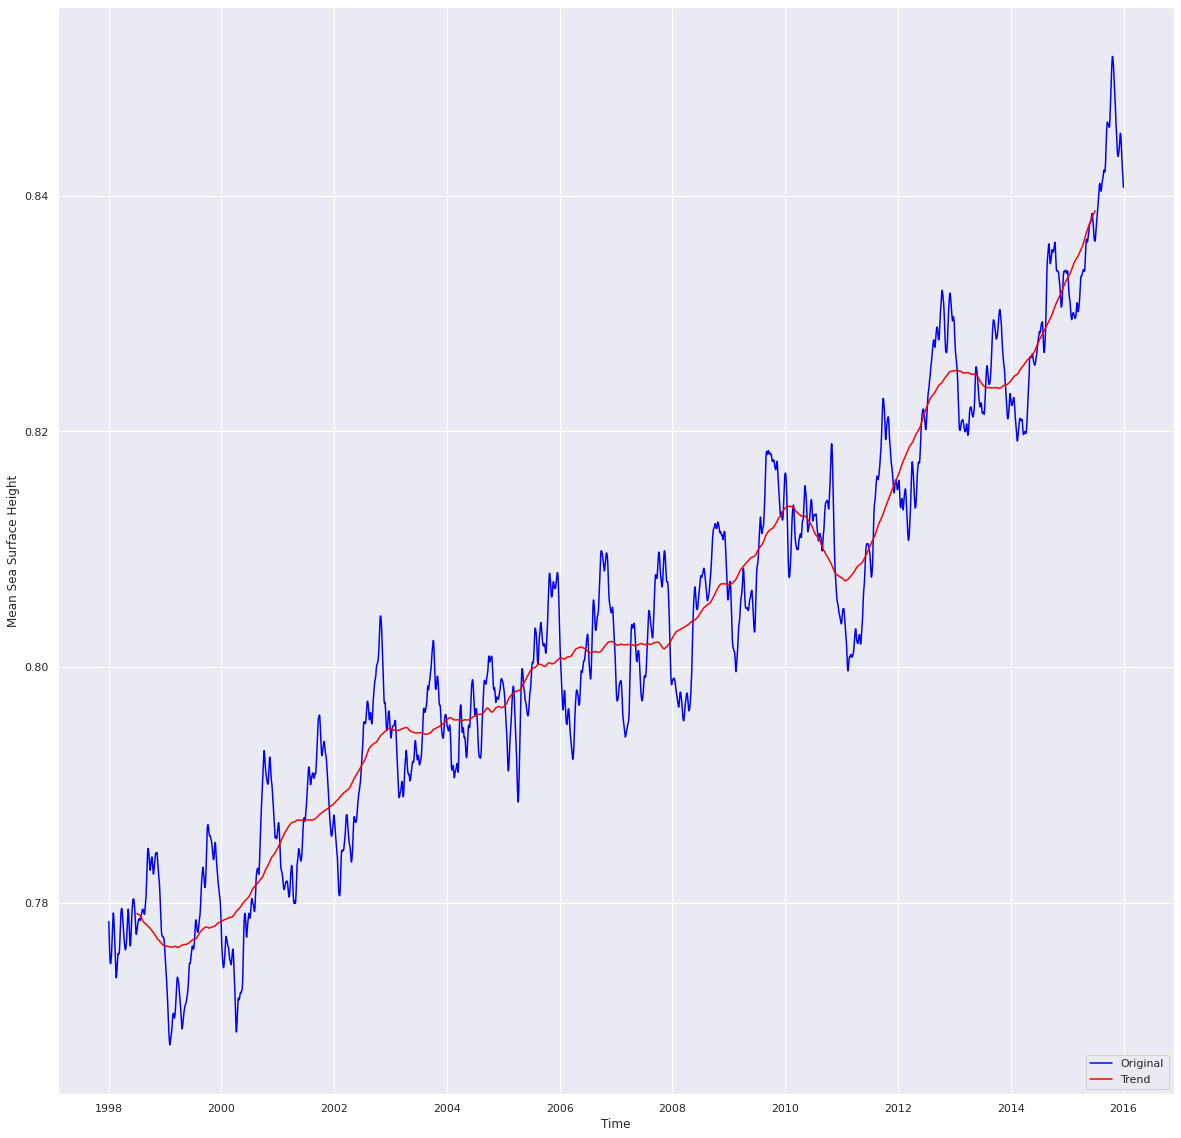

In [ ]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(mean_ssh_ts.index, mean_ssh_ts.values, c='blue', label='Original');
ax.plot(decomposition.trend.index, decomposition.trend, c='red', label='Trend');
ax.set_xlabel('Time')
ax.set_ylabel('Mean Sea Surface Height')
ax.legend(loc='lower right');

The trend shows the overall movement in the Mean SSH series, ignoring the seasonality and any small random fluctuations.

## b) Rolling mean

 Rolling mean (or moving average) is a common type of smoothing used in time series analysis and time series forecasting.

The rolling mean  requires that you specify a window size called the window width. This defines the number of raw observations used to calculate the moving average value.

The “moving” part in the moving average refers to the fact that the window is slid along the time series to calculate the average values in a new series.


#### Plotting Original Data and Rolling Mean on same plot

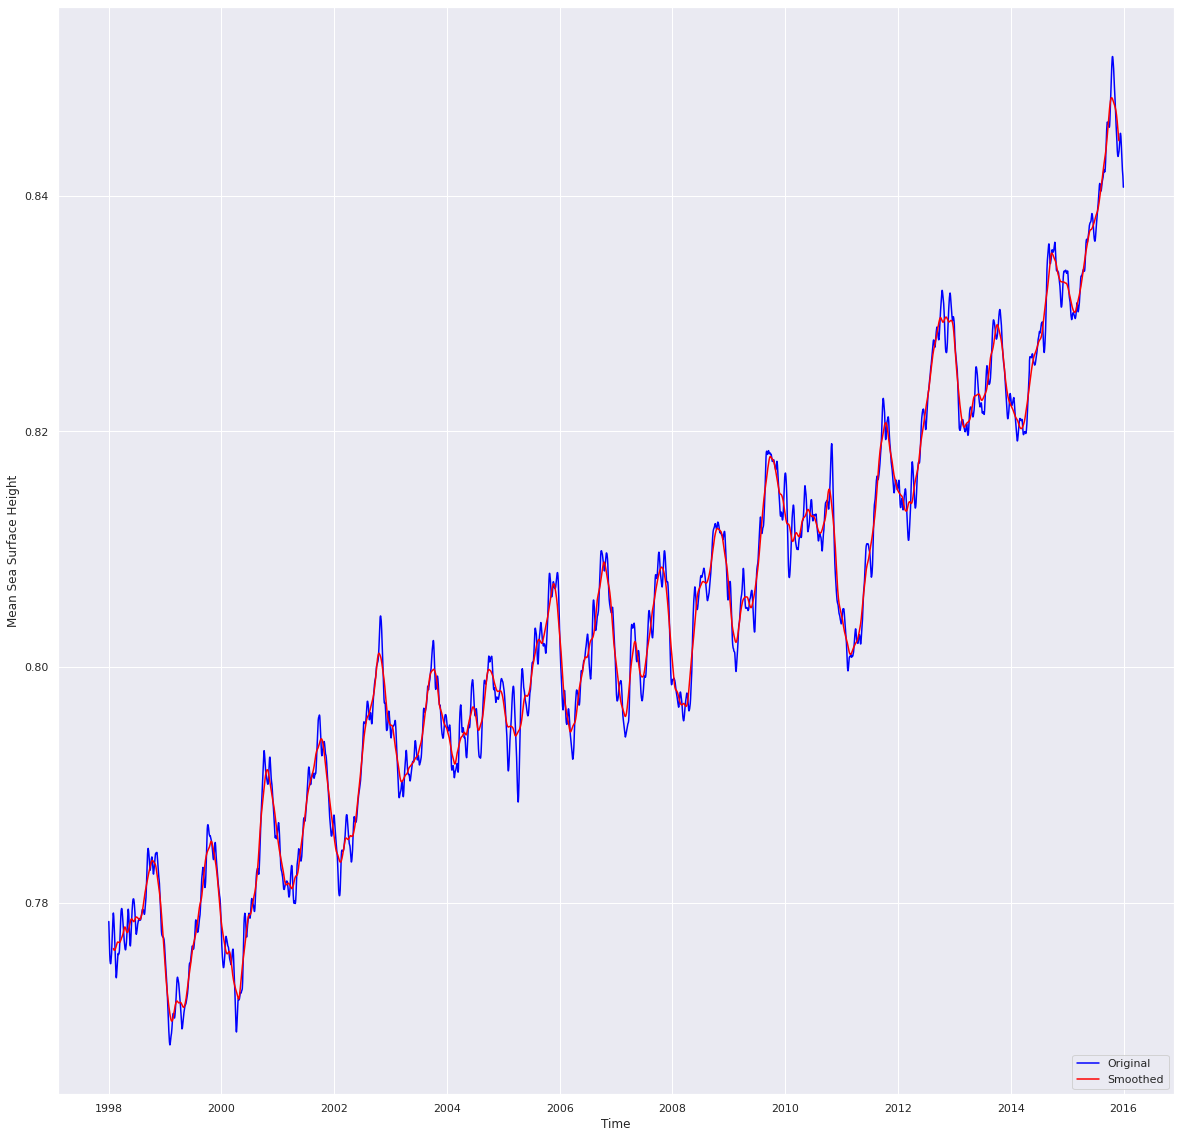

In [ ]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(mean_ssh_ts.index, mean_ssh_ts.values, c='blue', label='Original');
ax.plot(mean_ssh_ts.index, rolling_mean_ssh_ts.values, c='red', label='Smoothed');
ax.set_xlabel('Time')
ax.set_ylabel('Mean Sea Surface Height')
ax.legend(loc='lower right');

The rolling mean plot essentieally take the form of the original data and it remove the outliers by smoothing out short-term fluctuations in the mean SSH time series.

## c) Mean SSH by Week, Month and Year

In [ ]:
week_groupby=mean_ssh_ts.groupby(pd.Grouper(freq='W'))
week_mean=week_groupby.mean()
week_mean= pd.DataFrame(data = week_mean)
week_mean.columns = ['Weekly Mean SSH']

month_groupby=mean_ssh_ts.groupby(pd.Grouper(freq='M'))
month_mean=month_groupby.mean()
month_mean = pd.DataFrame(data = month_mean)
month_mean.columns = ['Monthly Mean SSH']

year_groupby=mean_ssh_ts.groupby(pd.Grouper(freq='A'))
year_mean=year_groupby.mean()
year_mean= pd.DataFrame(data = year_mean)
year_mean.columns = ['Yearly Mean SSH']

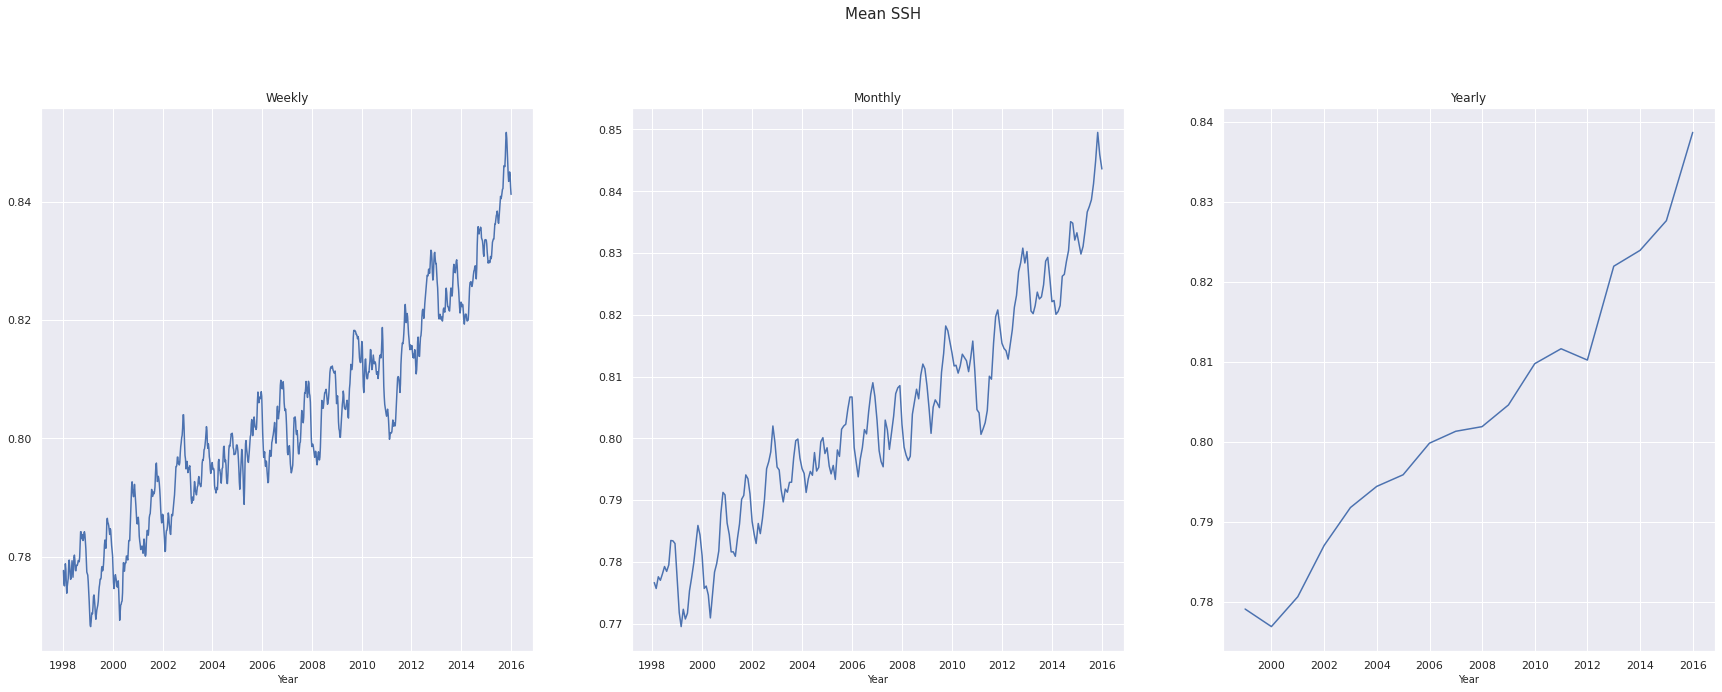

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30,10));
fig.suptitle('Mean SSH', size = 15, x = .515, y=1.02)
axes[0].plot(week_mean.index, week_mean.values);
axes[0].set_title('Weekly');
axes[0].set_xlabel('Year', fontsize=10);
axes[1].plot(month_mean.index, month_mean.values);
axes[1].set_title('Monthly');
axes[1].set_xlabel('Year', fontsize=10);
axes[2].plot(year_mean.index, year_mean.values);
axes[2].set_title('Yearly');
axes[2].set_xlabel('Year', fontsize=10);

the mean SSH by Week, Month and Year are basically following the trend of the time series.

By looking to the monthly mean SSH plot we can better observe the seasonality.



## d) Mean SSH Variation by Week, Month and Year

The variation here is the difference between the max and min values on the mean SSH by week, month and year

In [ ]:
week_difference=week_groupby.max()-week_groupby.min()
week_difference = pd.DataFrame(data = week_difference)
week_difference.columns = ['Weekly Mean SSH Variation']

month_difference=month_groupby.max()-month_groupby.min()
month_difference = pd.DataFrame(data = month_difference)
month_difference.columns = ['Monthly Mean SSH Variation']

year_difference=year_groupby.max()-year_groupby.min()
year_difference= pd.DataFrame(data = year_difference)
year_difference.columns = ['Yearly Mean SSH Variation']


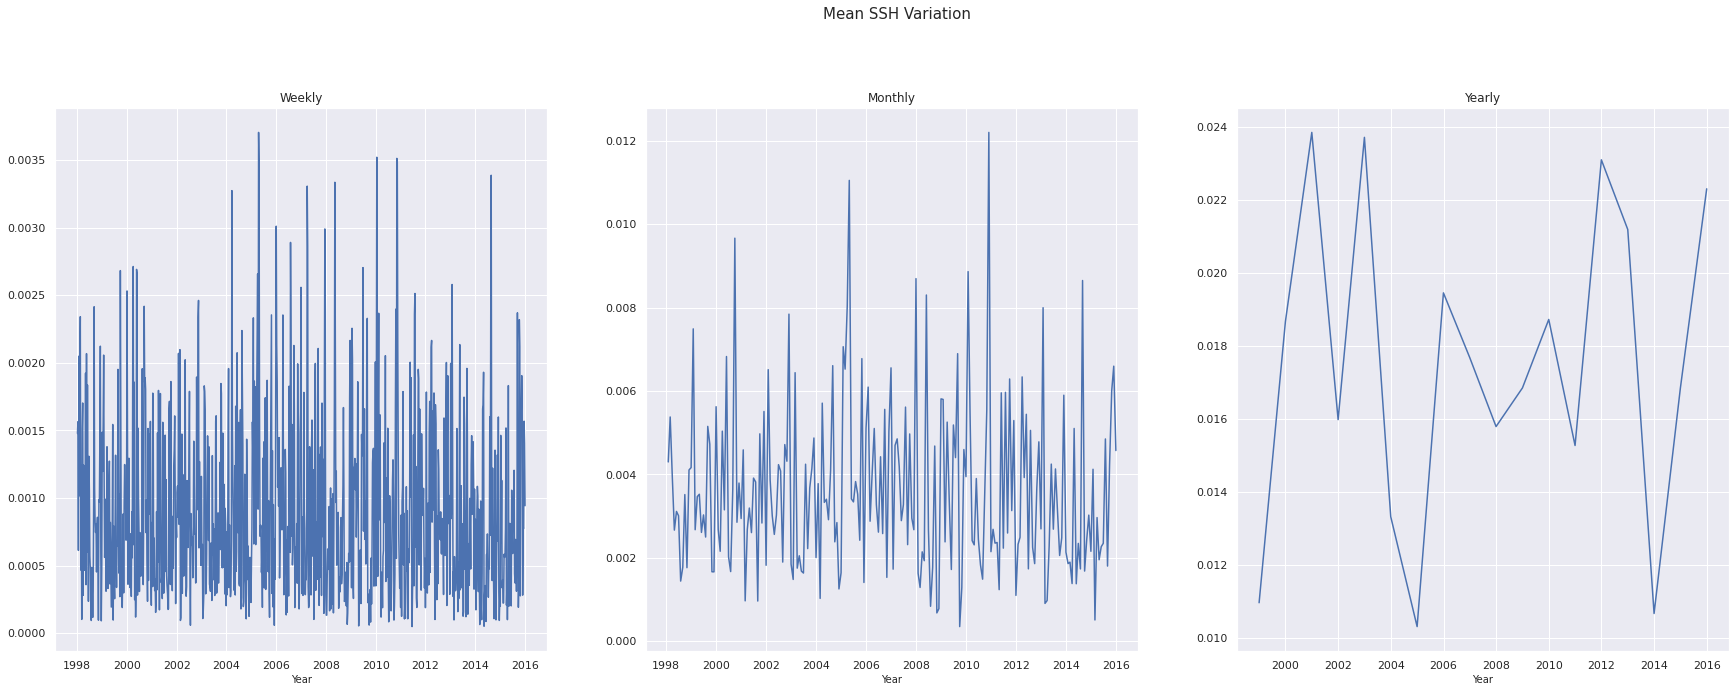

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30,10));
fig.suptitle('Mean SSH Variation', size = 15, x = .515, y=1.02)
axes[0].plot(week_difference.index, week_difference.values);
axes[0].set_title('Weekly');
axes[0].set_xlabel('Year', fontsize=10);
axes[1].plot(month_difference.index, month_difference.values);
axes[1].set_title('Monthly');
axes[1].set_xlabel('Year', fontsize=10);
axes[2].plot(year_difference.index, year_difference.values);
axes[2].set_title('Yearly');
axes[2].set_xlabel('Year', fontsize=10);

We can clearly see that the variations here are random.

But by focusing on the yearly variation of the mean SSH,  they are sometimes significant values of variations that reach more than 2 cm. So, this is due to both seasonality and unpredictable changes.

## e) Autocorrelation and Partial Autocorrelation

- Autocorrelation : The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
- Partial Autocorrelation : The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

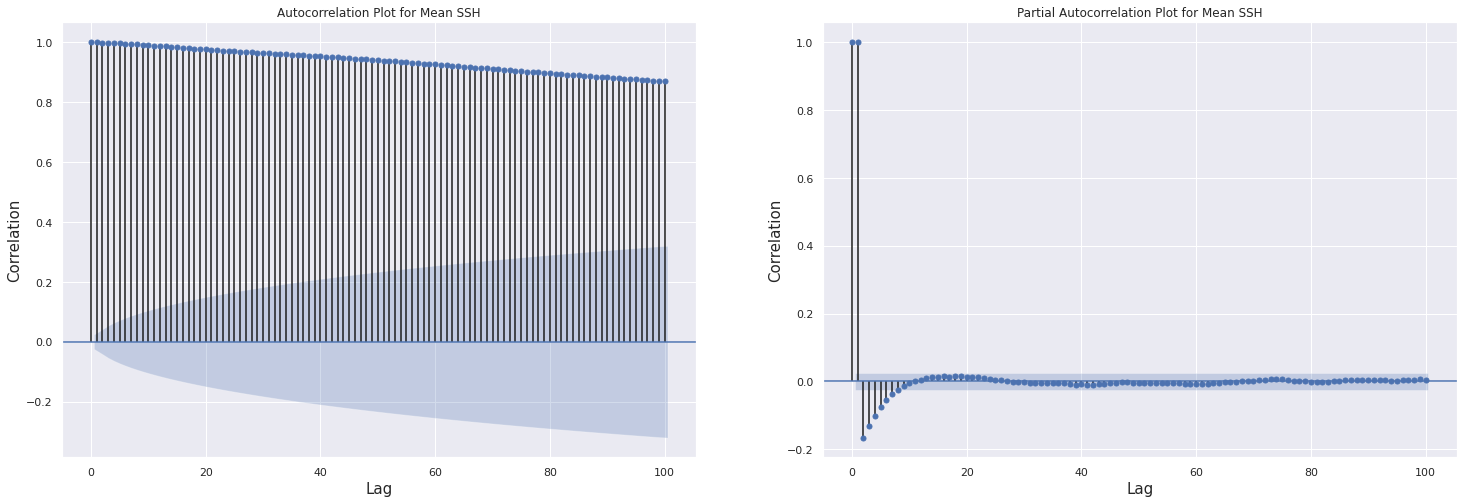

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# Plotting the autocorrelation
fig = plt.figure(figsize=(25,8))
ax1 = fig.add_subplot(121)
plot_acf(mean_ssh_ts.values,lags=100,ax=ax1,title="Autocorrelation Plot for Mean SSH")
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)

# Plotting the Partial autocorrelation
ax2 = fig.add_subplot(122)
plot_pacf(mean_ssh_ts.values,lags=100,ax=ax2,title="Partial Autocorrelation Plot for Mean SSH")
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.show()

- Autocorrelation :The first lags are close to 1 => they are statistically significant. We can conclude that the given time series is non-stationary
- Partial autocorrelation : partial autocorrelation after first 2 lags is very low.

## f) Check the Stationarity

Stationarity : stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time.

Augmented Dickey Fuller (ADCF) Test is implemented using statsmodels in python which performs a classic null hypothesis test and returns a p-value.

The Null-hypothesis for the test is that the time series is not stationary. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary.

The p-value is a probability used to make a decision on whether the null hypothesis being tested can be rejected or not. So, if p-value is less than 0.05 (p-value: low), we reject the null hypothesis and assume that the data is stationary. But if the p-value is more than 0.05 (p-value: high), then we fail to reject the null hypothesis and determine the data to be non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [ ]:
adf_test(mean_ssh_ts)

1. ADF :  -1.2453384162837096
2. P-Value :  0.6537947233432122
3. Num Of Lags :  32
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 6541
5. Critical Values :
	 1% :  -3.4313501327214255
	 5% :  -2.86198197343487
	 10% :  -2.5670052590498456


p>0.05 => Data is not stationary.


# **IV/ Prediction** 

## a) Creation of the model

We separate our data into train and test to evaluate each model with the test values.

In [ ]:
y_train,x_train,y_test,x_test = data.mean_ssh[0:int(6574*0.8),None],data.time[0:int(6574*0.8),None],data.mean_ssh[int(6574*0.8):,None],data.time[int(6574*0.8):,None]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


To evaluate the error, we use the MSE.

In [ ]:
def mse(y_pred,y):
  error = sklearn.metrics.mean_squared_error(y,y_pred)
  return error

#### 1) Linear regression

Fist, we use a simple linear regression to modelise our data. 

slope : [[7.60223723e-06]]


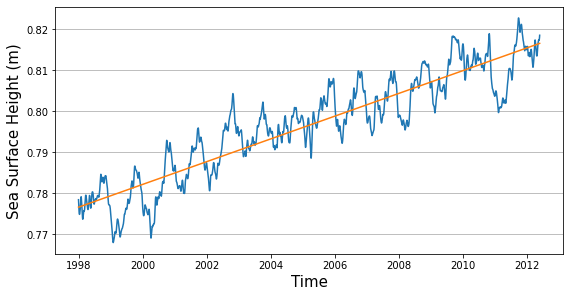

In [ ]:
### Here we create and visualise the model 

from sklearn.linear_model import LinearRegression

# create the model
model = LinearRegression()

# fit the model
model.fit(x_train, y_train)

print('slope : {}'.format(model.coef_))

# predict the training values calculated with the model 
y_hatt = model.predict(x_train)

# plot the values form 1998 to 2012
plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x_train,y_train,'-','Sea Surface Height (m)')
plot_ts(x_train,y_hatt,'-','Sea Surface Height (m)')
plt.title('Linear model between 1998 and 2012', fontsize=15)
grid(axis='y')

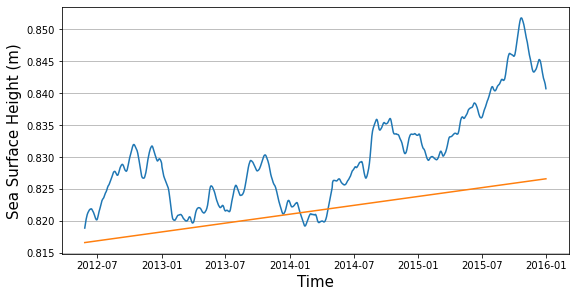

In [ ]:
### Then we test our model on the test data

# get the predicted values
y_hat = model.predict(x_test)

# plot the result of the prediction
plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x_test,y_test,'-','Sea Surface Height (m)')
plot_ts(x_test,y_hat,'-','Sea Surface Height (m)')
plt.title('Linear model prediction', fontsize=15)
grid(axis='y')

In [ ]:
### Calculate the error

# get the mse of the predicted values compared with the real ones
mse(y_hat,y_test)

9.68161200462663e-05

When we visualize the results of a simple linear model, we see that it does well for the data between 1998 and 2014 but for the last two years, the model doesn't fit the real data. Indeed if we do another linear regression based on these two years, the slope will be higher. Thus maybe a linear regression model based on a*t is not efficient. Indeed the rise in sea level each year is not the same (in mm/year). In 2015, The average temperature at the surface of the globe broke all records.  (https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature) 


In [ ]:
%%bigquery --project alert-ground-261008 temperature
SELECT time, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-35 AND lat<35
GROUP BY time
ORDER BY time

Text(0.5, 1.0, 'Sea surface temperature average between 1998 and 2015')

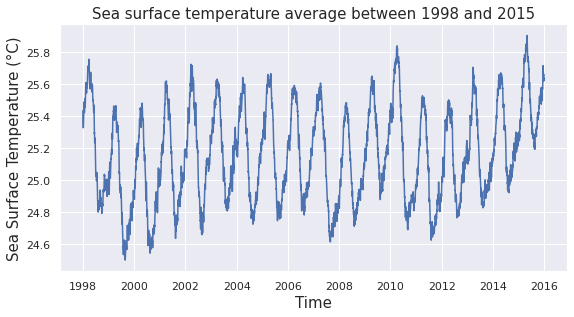

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(temperature.time,temperature.mean_sst,'-','Sea Surface Temperature (°C)')
plt.title('Sea surface temperature average between 1998 and 2015', fontsize=15)

#### 2) Multiple linear regression

To improve our model, we use a multiple linear regression.

In [ ]:
y_train,x_train,y_test,x_test = data.mean_ssh[0:int(6574*0.8)],data.time[0:int(6574*0.8)],data.mean_ssh[int(6574*0.8):],data.time[int(6574*0.8):]

In [ ]:
### We create the model

omega=1 / 365.25
x1 = x_train
x2 = np.sin(2 * np.pi * omega * x_train)
x3 = np.cos(2 * np.pi * omega * x_train)

y = y_train

X = np.vstack((x1, x2, x3)).T

from sklearn.linear_model import LinearRegression

# create the model
model = LinearRegression()

# fit the model
model.fit(X,y)

a1, a2, a3 = model.coef_
b = model.intercept_
print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

Model coefficients for [a1, a2, a3]: [ 7.59216226e-06 -4.64470132e-03 -1.37431790e-03]
Model coefficient for b: -4.760897479663667


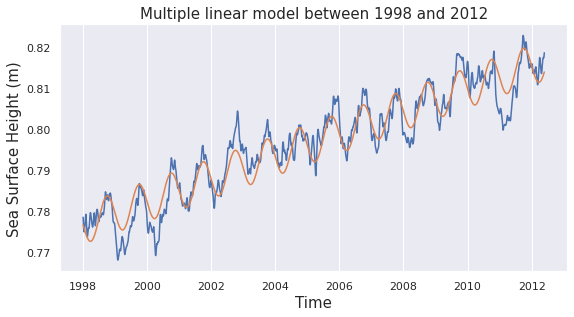

In [ ]:
### We visualise the model created

# predict the training values calculated with the model
y_hatt = model.predict(X)

# plot the values form 1998 to 2012
plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x_train,y_train,'-','Sea Surface Height (m)')
plot_ts(x_train,y_hatt,'-','Sea Surface Height (m)')
plt.title('Multiple linear model between 1998 and 2012', fontsize=15)
grid(axis='y')

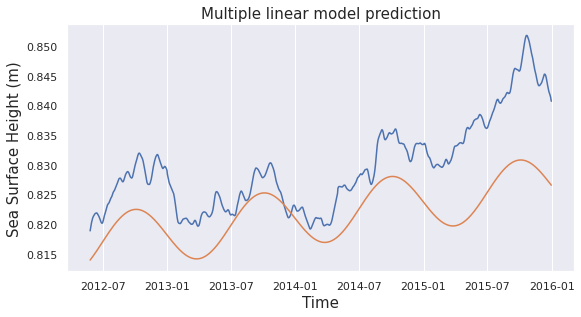

In [ ]:
### We test our model on the test data

omega=1 / 365.25
x1 = x_test
x2 = np.sin(2 * np.pi * omega * x_test)
x3 = np.cos(2 * np.pi * omega * x_test)

X_test = np.vstack((x1, x2, x3)).T

# get the predicted values
y_hat = model.predict(X_test)

# plot the result of the prediction
plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x_test,y_test,'-','Sea Surface Height (m)')
plot_ts(x_test,y_hat,'-','Sea Surface Height (m)')
plt.title('Multiple linear model prediction', fontsize=15)
grid(axis='y')

In [ ]:
### Calculate the error

# get the mse of the predicted values compared with the real ones
mse(y_hat,y_test)

7.747667405143468e-05

In [ ]:
### Error to compare with the model based on the rolling mean

mse(y_hat[:-100],y_test[:-100])

6.003059207717283e-05

The mse of 7.74e-5 has improved. Previously it was of 9.68e-5. Indeed we keep the same base of at+b but we add the seasonal cycle of the sea surface height as the temperature of the ocean changes over the year. 

#### 3) SVR

In [ ]:
y_train,x_train,y_test,x_test = data.mean_ssh[0:int(6574*0.8),None],data.time[0:int(6574*0.8),None],data.mean_ssh[int(6574*0.8):,None],data.time[int(6574*0.8):,None]

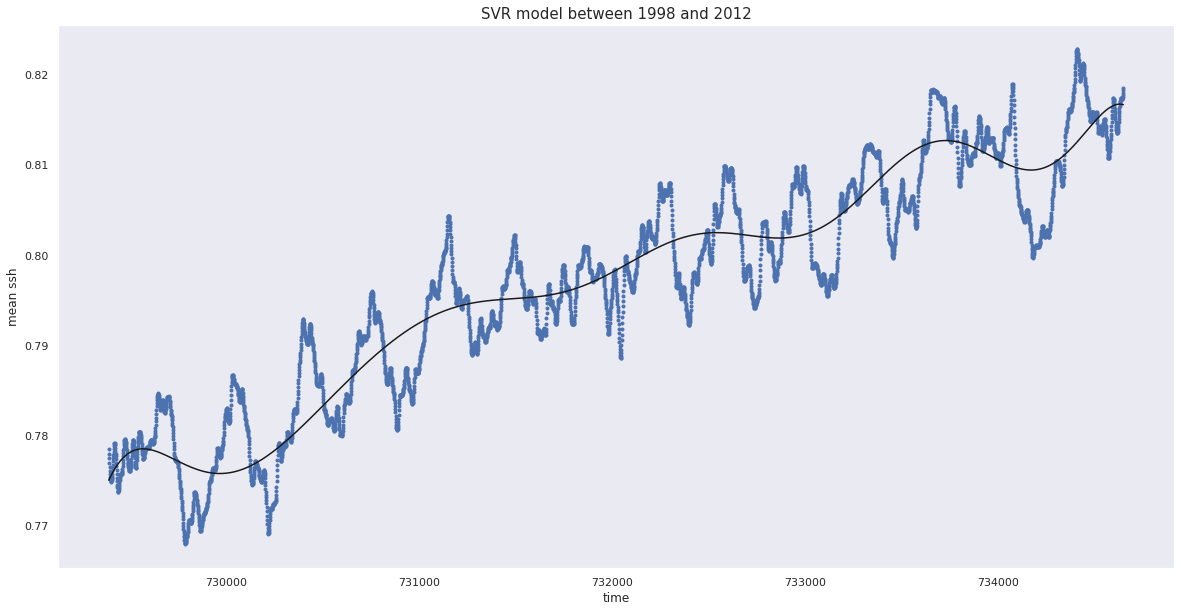

In [ ]:
from sklearn.svm import SVR

epsilon = 0.000005

# create the model
model=SVR(C=100, epsilon=epsilon)

# fit the model
model.fit(x_train,y_train)

# predict the training values calculated with the model
y_hatt=model.predict(x_train)

# plot the values form 1998 to 2012
plt.plot(x_train,y_train,'.')
plt.plot(x_train,y_hatt,'k-')
plt.xlabel('time')
plt.ylabel('mean ssh')
plt.title('SVR model between 1998 and 2012', fontsize=15)
plt.grid()

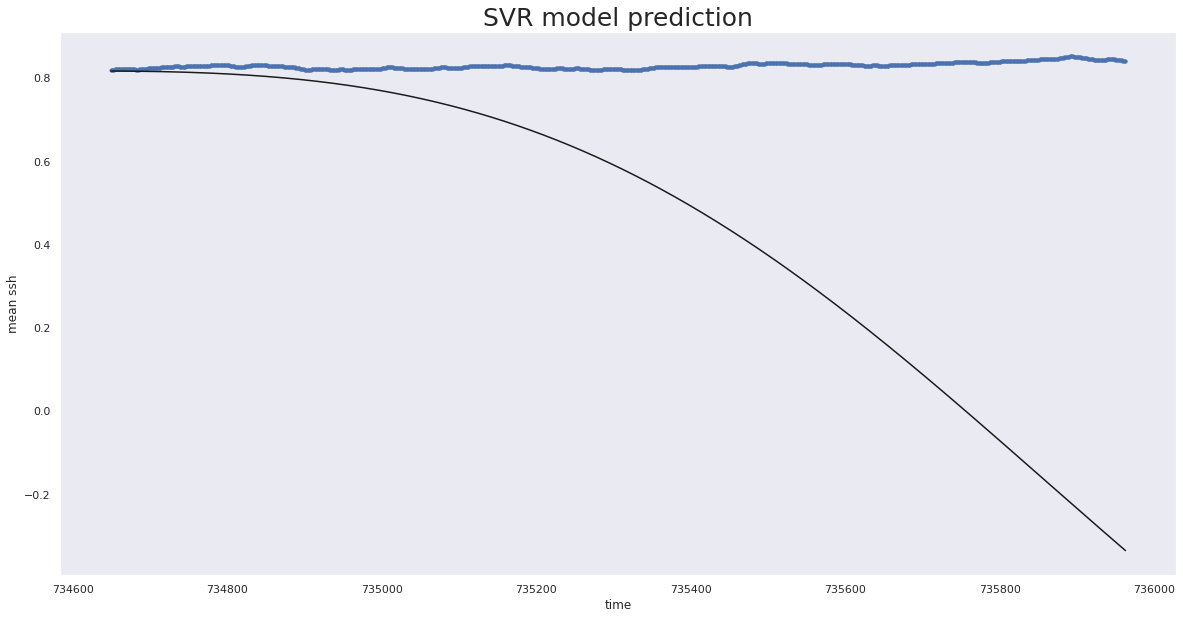

In [ ]:
### We test our model on the test data

# get the predicted values
y_hat=model.predict(x_test)

# plot the result of the prediction
plt.plot(x_test,y_test,'.')
plt.plot(x_test,y_hat,'k-')
plt.xlabel('time')
plt.ylabel('mean ssh')
plt.title('SVR model prediction', fontsize=25)
plt.grid()

In [ ]:
### Calculate the error

# get the mse of the predicted values compared with the real ones
mse(y_hat,y_test)

0.2676841531414715

We can see that the SVR is not great when it comes to prediction. Indeed it is a non-parametric model (non-parametric does not mean that it have no parameters! the difference is that  in a parametric model, we have a finite number of parameters, and in nonparametric models, the number of parameters can be potentially infinite.  In other words, in nonparametric models, the complexity of the model grows with the number of training data)
Sometimes, the non-parametric models tend to be more computationally intensive, and to have less numerically stable solutions. As we  can see in our case, the SVR model give us unreasonable results when predecting the Test set

#### 4) Rolling mean

To minimize the importance of the outliers, we use the rolling to mean to construct our model. We use again our multiple linear regression.

In [ ]:
from pandas import DataFrame
df = DataFrame(data)
df.columns = data.keys()
np.shape(df)

(6574, 2)

In [ ]:
### first we calculate the rolling mean

w=100
rolling_mean_ssh=df.rolling(window = w, center=True).mean()

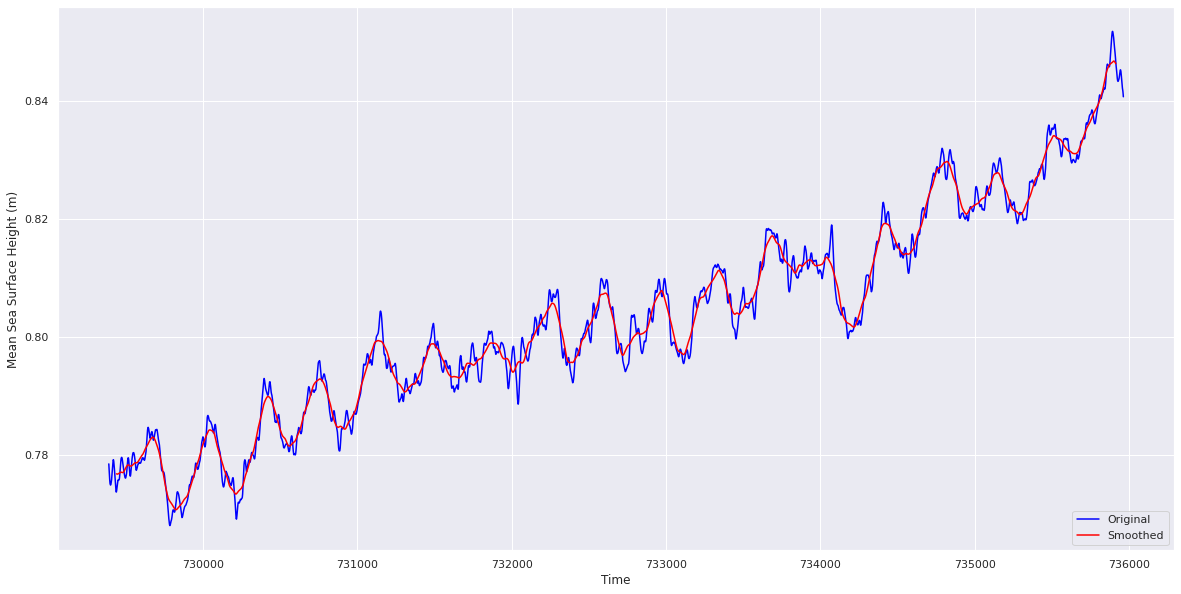

In [ ]:
### Then we visualise it 

fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(df['time'], df['mean_ssh'], c='blue', label='Original');
ax.plot(df['time'], rolling_mean_ssh['mean_ssh'], c='red', label='Smoothed');
ax.set_xlabel('Time')
ax.set_ylabel('Mean Sea Surface Height (m)')
ax.legend(loc='lower right');

In [ ]:
### We train and test our algorithm with the data of the rolling mean

y_train,x_train,y_test,x_test = rolling_mean_ssh['mean_ssh'][w:int(6574*0.8)],data.time[w:int(6574*0.8)],rolling_mean_ssh['mean_ssh'][int(6574*0.8):-w],data.time[int(6574*0.8):-w]

In [ ]:
### We use the same model as seen previously

omega=1 / 365.25
x1 = x_train
x2 = np.sin(2 * np.pi * omega * x_train)
x3 = np.cos(2 * np.pi * omega * x_train)

y = y_train

X = np.vstack((x1, x2, x3)).T

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

a1, a2, a3 = model.coef_
b = model.intercept_
print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

Model coefficients for [a1, a2, a3]: [ 7.66284709e-06 -4.15504061e-03 -1.24762536e-03]
Model coefficient for b: -4.812696445715805


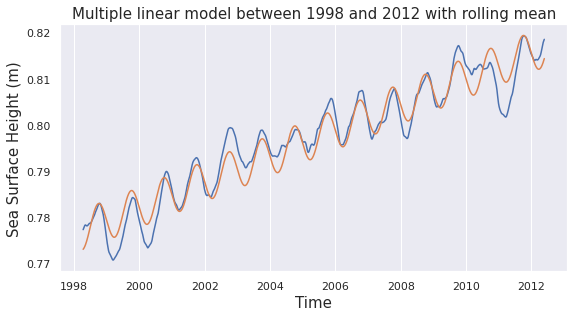

In [ ]:
y_hatt = model.predict(X)

plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x_train,y_train,'-','Sea Surface Height (m)')
plot_ts(x_train,y_hatt,'-','Sea Surface Height (m)')
plt.title('Multiple linear model between 1998 and 2012 with rolling mean', fontsize=15)
grid(axis='y')

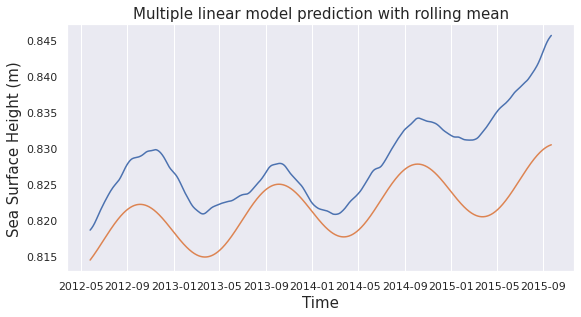

In [ ]:
omega=1 / 365.25
x1 = x_test
x2 = np.sin(2 * np.pi * omega * x_test)
x3 = np.cos(2 * np.pi * omega * x_test)

X_test = np.vstack((x1, x2, x3)).T

# get the predicted values
y_hat = model.predict(X_test)

plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x_test,y_test,'-','Sea Surface Height (m)')
plot_ts(x_test,y_hat,'-','Sea Surface Height (m)')
plt.title('Multiple linear model prediction with rolling mean', fontsize=15)
grid(axis='y')

In [ ]:
mse(y_hat,data.mean_ssh[int(6574*0.8):-w])

5.7570508072151665e-05

The mse is of 5.76e-05 which is lower than the previous mse of 7.74e-05. However here we don't take into account the last 100 values of the series. And these values are those with the highest error. If we calculate the error of the second model with the last 100 values, we have a mse of 6.00e-05.Therefore the rolling mean is not so eficient in order to have a better model.

## b) Prediction

#### 1) Multiple linear regression

The best model for this time series seems to be the multiple linear regression. Thus we will do our predictions with the help of such models.  

In [ ]:
x = data.time
y = data.mean_ssh

omega=1 / 365.25
x1 = x
x2 = np.sin(2 * np.pi * omega * x)
x3 = np.cos(2 * np.pi * omega * x)


X = np.vstack((x1, x2, x3)).T
print('The shape of X is {}'.format(X.shape))

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

a1, a2, a3 = model.coef_
b = model.intercept_
print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

The shape of X is (6574, 3)
Model coefficients for [a1, a2, a3]: [ 8.74525294e-06 -4.78463786e-03 -1.42799020e-03]
Model coefficient for b: -5.604237677597884


0.939701595589812

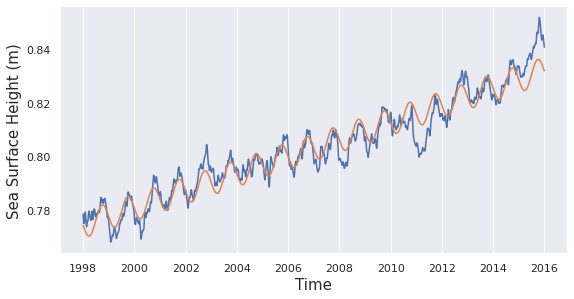

In [ ]:
y_hatt = model.predict(X)

plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x,y,'-','Sea Surface Height (m)')
plot_ts(x,y_hatt,'-','Sea Surface Height (m)')
grid(axis='y')

sklearn.metrics.r2_score(y,y_hatt)

In [ ]:
x_2100=max(x)+85*365
pred_model = 8.74525294e-06*x_2100 - 4.78463786e-03*np.sin(2 * np.pi * omega * x_2100) - 1.42799020e-03*np.cos(2 * np.pi * omega * x_2100) - 5.604237677597884
print(pred_model)

1.1049618876286669


This model predict a sea surface height of 1,105 m for 2100.

In [ ]:
# Creating a datetimeindex specifying start date , end date
pred_date = np.linspace(730000,730000+85*12+int(85/4), 85*12+int(85/4))

In [ ]:
pred_date[:,None]

array([[730000.        ],
       [730001.00096154],
       [730002.00192308],
       ...,
       [731038.99807692],
       [731039.99903846],
       [731041.        ]])

In [ ]:
omega=1 / 365.25
x = pred_date[:,None]
x1 = x
x2 = np.sin(2 * np.pi * omega * x)
x3 = np.cos(2 * np.pi * omega * x)


X_pred = np.vstack((x1, x2, x3)).T
print('The shape of X is {}'.format(X.shape))

y_hat = model.predict(X_pred)

The shape of X is (6574, 3)


ValueError: ignored

However as we see previous in the linear model, the increase of the last two years seems to be overlooked by a model based on a linear regression. (Here it's based on a x t with cos and sin).
Therefore, it is prehaps useful to and a term in t^2.

In [ ]:
x = data.time
y = data.mean_ssh

omega=1 / 365.25
x1 = x
x2 = np.sin(2 * np.pi * omega * x)
x3 = np.cos(2 * np.pi * omega * x)

# We add the term in t^2
x4 = x*x


X = np.vstack((x1, x2, x3, x4)).T
print('The shape of X is {}'.format(X.shape))
print('The shape of y is {}'.format(y.shape))

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

a1, a2, a3, a4 = model.coef_
b = model.intercept_
print('Model coefficients for [a1, a2, a3]: {}'.format(model.coef_))
print('Model coefficient for b: {}'.format(model.intercept_))

The shape of X is (6574, 4)
The shape of y is (6574,)
Model coefficients for [a1, a2, a3]: [-6.59079185e-04 -4.78319309e-03 -1.43346446e-03  4.55743045e-10]
Model coefficient for b: 239.04375695190393


0.9466141208525015

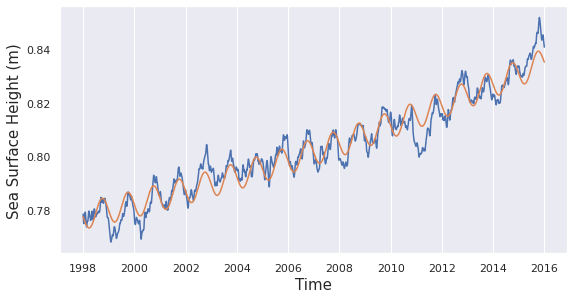

In [ ]:
y_hatt = model.predict(X)

plt.rcParams["figure.figsize"] = (20,10)
subplot(221)
plot_ts(x,y,'-','Sea Surface Height (m)')
plot_ts(x,y_hatt,'-','Sea Surface Height (m)')
grid(axis='y')

sklearn.metrics.r2_score(y,y_hatt)

In [ ]:
x_2100 = max(x)+85*365 + int(85/4)
pred_model = - 6.59079185e-04*x_2100 - 4.78319309e-03*np.sin(2 * np.pi * omega * x_2100) - 1.43346446e-03*np.cos(2 * np.pi * omega * x_2100) + 4.55743045e-10*x_2100*x_2100 + 239.04375695190393
print(pred_model)

1.6389230209252617


Now, this model predict a sea surface height of 1,639 m for 2100.

These two different models give quite different results. First we have a level of 1,1 m and then of 1,64 m. Thus we will try another model to see which results seems to be the most likely prediction.

If we look at the r2 score, the second model fit more the given data than the first.

#### 2) ARIMA

TUTORIAL:
A Guide to Time Series Forecasting with ARIMA in Python 3
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [ ]:
%%bigquery --project alert-ground-261008 data_arima
SELECT AVG(ssh) AS mean_ssh,
EXTRACT(YEAR FROM DATE_ADD(DATE "0001-1-1", INTERVAL CAST(time as INT64) DAY)) as year,
EXTRACT(MONTH FROM DATE_ADD(DATE "0001-1-1", INTERVAL CAST(time as INT64) DAY)) as monthofyear,
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-35 AND lat<35
GROUP BY year, monthofyear
ORDER BY year, monthofyear

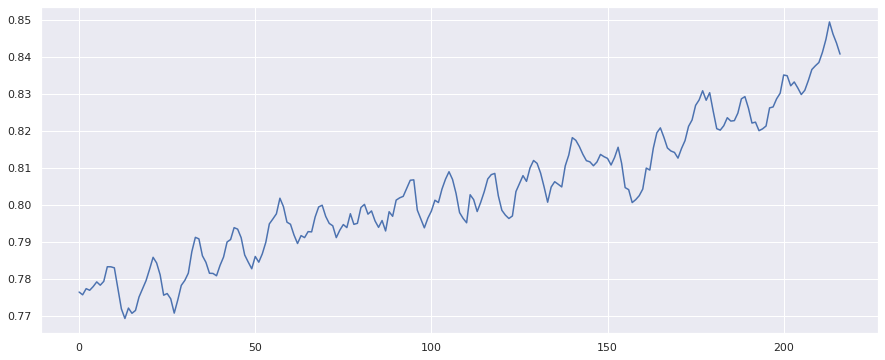

In [ ]:
y = data_arima.mean_ssh

y.plot(figsize=(15, 6))
show()

In [ ]:
import statsmodels.api as sm
import itertools


p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:520.5535860756025
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:496.2731279968735
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-1487.4352764394234
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-1392.109015679941
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-1571.649174719954
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-1614.1800293696483
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-1400.202545295103
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-1390.4003371715078
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:228.61340539518022
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:223.22143229598709
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-1630.6028775891782
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-1526.1720407511407
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-1678.502255420108
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-1715.830213484168
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-1542.166517184235
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-1523.1138967369188
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-1907.4948048292003
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-1804.

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5956      0.173      3.440      0.001       0.256       0.935
ma.L1         -0.7875      0.128     -6.151      0.000      -1.038      -0.537
ar.S.L12      -0.2761      0.112     -2.463      0.014      -0.496      -0.056
ma.S.L12      -0.4764      0.116     -4.114      0.000      -0.703      -0.249
sigma2       5.12e-06   5.69e-07      9.003      0.000    4.01e-06    6.23e-06


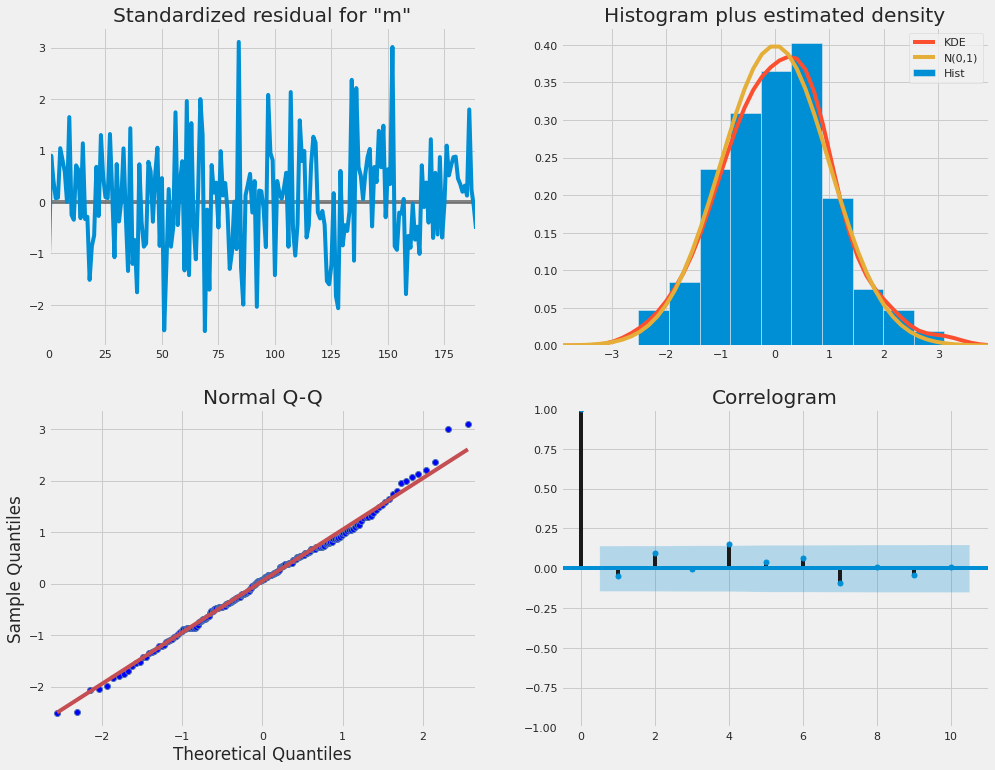

In [ ]:
style.use('fivethirtyeight')
results.plot_diagnostics(figsize=(15, 12))
show()

1) Residuals are randomly distributed around 0 : the model seems to have understand all the dynamics of the data
2) Residuals are near a normal distribution (histogram + normal Q-Q). It seems that the model is quite accurate.
3) The autocorrelation bars are in the confidence interval

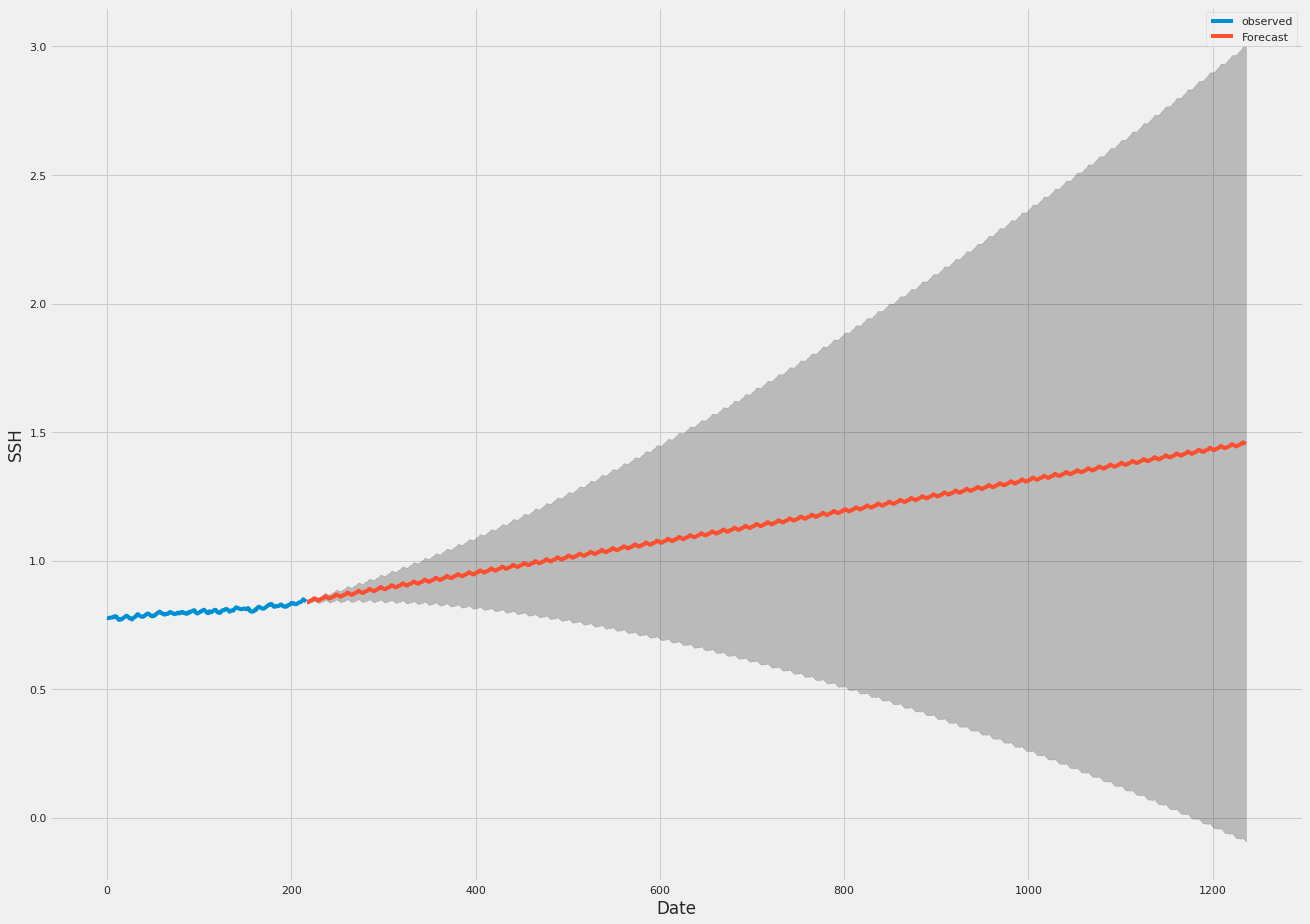

In [ ]:
# Get forecast 85 years ahead in future (85 years * 12 months = 1020)
pred_uc = results.get_forecast(steps=1020)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('SSH')

plt.legend()
plt.show()

Our forecasts are consistent with those assuming a constant trend and with NOAA's low intermediate and intermediate forecasts. Climatologists predict an acceleration of sea surface rise. The sea level could therefore be much higher by 2100.

Climate-change–driven accelerated sea-level rise detected in the altimeter era.
R. S. Nerema,1, B. D. Beckleyb, J. T. Fasulloc, B. D. Hamlingtond, D. Mastersa
, and G. T. Mitchume